In [1]:
from lib.main_func_p1 import timer, path
import pandas as pd
from importlib import reload
from collections import OrderedDict
import lib.main_func_p4
from lib.main_func_p4 import modelXGBoost_fit_scores


#XGBoost library
import xgboost as xgb


In [2]:
#####################################
# proteina (uniprot_ID)
uniprot_id = 'P49841'
path_file = path(uniprot_id)

# Archivo de la carpeta TOP SOCORE
excel_name = f'{uniprot_id}/P49841_20220628123407_top_scores_XGBClassifier_f1_weighted_rf0'
resample_factor = int(str.split(excel_name,'_')[-1][2:])
resample_mode = 'under_sampling'

# Parametros
seed = 142854
fp_name = 'morgan2_c'

In [3]:
# Load top_scores
top_scores = pd.read_excel(f'./top_scores/{excel_name}.xlsx')

# Best calibration scores
top_socres_len = 1
top_scores_top = top_scores.iloc[:top_socres_len]
top_scores_top_index_list = top_scores_top.index
# top_scores_top.head()

In [4]:
reload(lib.main_func_p4)
from lib.main_func_p4 import modelXGBoost_fit_scores

# Load train and validation datasets
df_train = pd.read_pickle(f'{path_file}_dataset_train')
df_valid = pd.read_pickle(f'{path_file}_dataset_valid')

new_row_list = list()
results_ROF_list_train = list()
results_ROF_list_valid = list()
df_list = list()
plots_name_list = list()

for i, params_dict in enumerate(top_scores.params_dict.iloc[0:top_socres_len]):
    eval_metric = ['error', 'auc']
    tick = timer()
    params_dict = dict(eval(params_dict))
    default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                          'objective':'binary:logistic', 'grow_policy': 'depthwise',
                          'eval_metric': eval_metric, 'early_stopping_rounds':10}
    params_dict.update(default_params_xgb)

    xgb_clf = xgb.XGBClassifier(**params_dict)

    # Train model and evaluating scores (train / validation)
    xgb_clf, scores_train, scores_valid = modelXGBoost_fit_scores(xgb_clf, fp_name, df_train, df_valid,
                                                                  resample_factor=resample_factor,
                                                                  resample_mode=resample_mode)

    if i == 0:
        xgb_clf.save_model(f'./models/{uniprot_id}_model.ubj')
        print(f'Best model saved ({top_scores.model.iloc[i]})')

    # ROF results
    results_ROF_list_train.append(scores_train[7])
    results_ROF_list_valid.append(scores_valid[7])

    # save pred and pred_prob of train set
    df = df_train[['activity', 'prediction', 'prediction_prob']].copy()
    df_list.append(df)

    plots_name_list.append(top_scores.model.iloc[i])
    print(f'{i+1}/{top_socres_len}. {top_scores.model.iloc[i]}. AUC_score=(train={scores_train[0]},'
          f' valid={scores_valid[0]}). Time elapsed: {timer(tick)}')

Best model saved (modelID_495)
1/1. modelID_495. AUC_score=(train=0.996, valid=0.972). Time elapsed: 5.0 seconds.


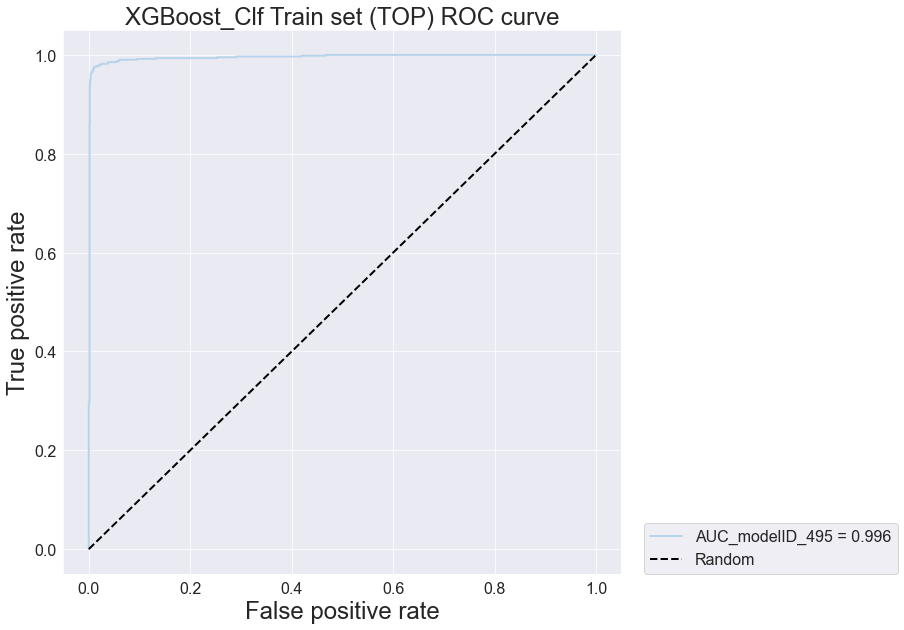

In [5]:
# ROC curve - best scores
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_ROC_curve
results_ROF_train_list_top = list()
results_ROF_valid_list_top = list()
ROC_plots_name_top_name = list()
for i in top_scores_top_index_list:
    results_ROF_train_list_top.append(results_ROF_list_train[i])
    results_ROF_valid_list_top.append(results_ROF_list_valid[i])
    ROC_plots_name_top_name.append(plots_name_list[i])

model_name = f'XGBoost_Clf Train set (TOP)'
plot_ROC_curve(results_ROF_train_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="train_Top_score", save_fig=True)

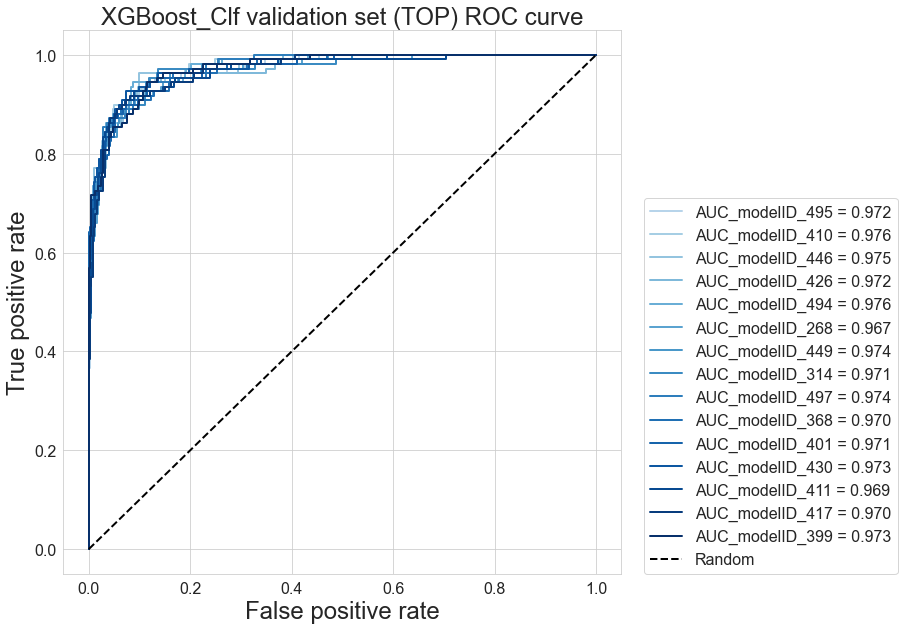

In [58]:
model_name = f'XGBoost_Clf validation set (TOP)'
plot_ROC_curve(results_ROF_valid_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="validation_Top_score", save_fig=True)

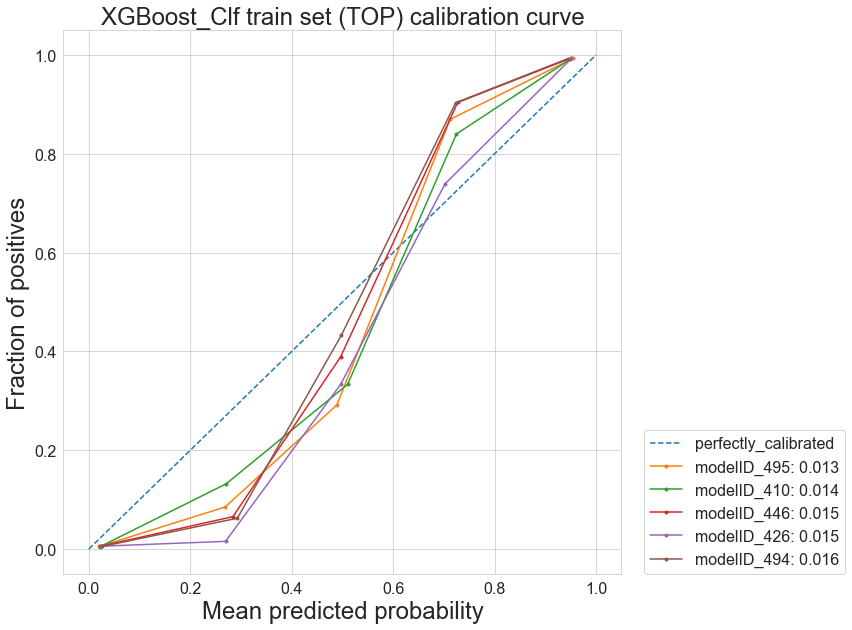

In [59]:
# Calibration curve - best scores (10)
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve
df_list_top = list()
df_list_top_name = list()
model_name = f'XGBoost_Clf train set (TOP)'
# Only graph top 5
for i in top_scores_top_index_list:
    df_list_top.append(df_list[i])
    df_list_top_name.append((plots_name_list[i]))
plot_calibration_curve(df_list_top[:5], df_list_top_name[:5], model_name,
                       path_file=path_file, name_mod="train_Top_score", save_fig=True)